### Configuering libs and data

In [1]:
## Standard libraries
import os
import math
import numpy as np
import pandas as pd
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)

Using device cuda


<Figure size 640x480 with 0 Axes>

In [2]:
!pip install geomloss

  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32247 sha256=5aafe1e1e36addcb794a021ff28d64ecb56eabe64e0897caa152fd98b5e5b94f
  Stored in directory: /root/.cache/pip/wheels/8c/4a/93/91d962ed04d2358b07000fb21b3164fd167b1b9cfddfce67fd
Successfully built geomloss


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Seting DIR
DIR = "/content/drive/My Drive/Project CVLAB/sampling"
os.makedirs(DIR, exist_ok=True)

Mounted at /content/drive


In [4]:
def scale(sample):
    return 2 * sample - 1

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), scale])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True)
val_loader   = data.DataLoader(val_set,   batch_size=128, shuffle=False, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=True)

print('Train size:', len(train_loader.dataset))
print('Validation size:', len(val_loader.dataset))
print('Test size:', len(test_loader.dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.36MB/s]


Train size: 50000
Validation size: 10000
Test size: 10000


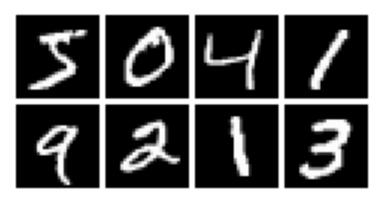

In [5]:
def show_tensor_image(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(img))


def show_imgs(imgs, nrows=1):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs        # T, img, ch, size, size or img, ch, size, size

    imgs = imgs.unsqueeze(0) if imgs.ndim == 4 else imgs                # T, img, ch, size, size
    imgs = imgs.transpose(1, 0)                                         # img, T, ch, size, size
    imgs = imgs.reshape((-1,) + imgs.shape[2:])                         # img * T, ch, size, size

    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
    show_tensor_image(grid.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_dataset[i][0] for i in range(8)], nrows=2)

### model componenets

In [6]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(2 * in_chs, out_chs, 3, 2, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self, T, img_shape):
        super(UNet, self).__init__()
        self.T = T

        img_chs = img_shape[0]
        down_chs = (64, 128, 128)
        up_chs = down_chs[::-1]               # Reverse of the down channels
        latent_image_size = img_shape[1] // 4 # 2 ** (len(down_chs) - 1)

        # New
        t_embed_dim = 8

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim) # New
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[0]) # New
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[1]) # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[2], up_chs[2], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        # time step normalized
        norm_t = t.float() / float(self.T)

        # down
        down_0 = self.down0(x)
        down_1 = self.down1(down_0)
        down_2 = self.down2(down_1)

        # latent
        latent = self.to_vec(down_2)
        latent = self.dense_emb(latent)

        # time
        time = self.sinusoidaltime(norm_t)
        time_1 = self.temb_1(time)
        time_2 = self.temb_2(time)

        # up
        up_0 = self.up0(latent)
        up_0 = up_0 + time_1
        up_1 = self.up1(up_0, down_2)
        up_1 = up_1 + time_2
        up_2 = self.up2(up_1, down_1)
        out = self.out(torch.cat((up_2, down_0), 1))
        return out


In [8]:
from geomloss import SamplesLoss
from math import sqrt
import random



reg = 0.01

compute_ot_cost = SamplesLoss("sinkhorn", p=2, blur= sqrt(reg))

In [9]:
class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(96, 192, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, 1, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(384*5*5, latent_dim)
        self.fc_out  = nn.Linear(latent_dim, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        feat = F.relu(self.fc_feat(x))
        out = self.fc_out(feat)
        return out, feat

state_dict = torch.load(os.path.join(DIR, "EncoderNEW.pth"), map_location=device)
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}

netEncoder = SimpleMNISTFeatureNet()
netEncoder.load_state_dict(new_state_dict)
netEncoder.to(device)

SimpleMNISTFeatureNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_feat): Linear(in_features=9600, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)

### model

In [10]:
class DDPM(nn.Module):
    def __init__(self, T, img_shape, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon=0.008
        if method == 'cosine':
            steps=torch.linspace(0,T,steps=T+1).to(device)
            f_t=torch.cos(((steps/T+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
            self.Beta = torch.clip(1.0-f_t[1:]/f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.img_chs = img_shape[0]
        self.img_size = img_shape[1]

        self.net = UNet(T, img_shape)

        # Logging
        self.logs = defaultdict(list)

    def log(self, key, value):
        self.logs[key].append(value)

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns a tuple (img_after_noise, noise) at timestep t
        x_0: the original image
        t: timestep
        """

        # noise
        noise = torch.randn_like(x_0).to(device)

        #  scaling factors
        alpha_bar_t = self.a_bar[t]
        sqrt_ab = torch.sqrt(alpha_bar_t).reshape(-1, 1, 1, 1)
        sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar_t).reshape(-1, 1, 1, 1)

        # forward diffusion formula
        scaled_x0 = sqrt_ab * x_0
        scaled_noise = sqrt_one_minus_ab * noise
        x_t = scaled_x0 + scaled_noise

        return x_t, noise



    def get_x0_pred(self, x_t, t, e_t):

        alpha_bar_t = self.a_bar[t].reshape(-1, 1, 1, 1)

        x_0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * e_t) / torch.sqrt(alpha_bar_t)
        x_0_pred = x_0_pred.clamp(-1, 1)
        return x_0_pred

    def reverse_q(self, x_t, t, e_t):
        # parameters for timestep t
        alpha_t = self.a[t]
        alpha_bar_t = self.a_bar[t]
        beta_t = self.Beta[t]
        sigma_t = torch.sqrt(beta_t)

        # noise injection
        noise = torch.randn_like(x_t).to(device) if t > 0 else 0

        coef = (1 - alpha_t) / torch.sqrt(alpha_bar_t)
        denominator = torch.sqrt(alpha_t)
        x_denoised = x_t - coef * e_t
        x_prev = x_denoised / denominator + noise * sigma_t
        x_prev.clamp_(-1, 1)

        return x_prev


    def get_loss(self, x_0, t):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        x_t, true_noise = self.q(x_0, t)
        predicted_noise = self.net(x_t, t)
        loss = F.mse_loss(predicted_noise, true_noise)

        return loss


    def sample(self, num_imgs=1, skip=1):
        self.eval()

        x_t = torch.randn(num_imgs, self.img_chs, self.img_size, self.img_size).to(device)
        output = []

        # reverse diffusion loop
        for t in reversed(range(self.T)):
            # ---- save model params ----
            net_state = {k: v.clone() for k, v in self.net.state_dict().items()}
            encoder_state = {k: v.clone() for k, v in netEncoder.state_dict().items()}

            # disable grads
            for p in self.net.parameters():
                p.requires_grad_(False)
            for p in netEncoder.parameters():
                p.requires_grad_(False)

            # do sampling step
            t_batch = torch.full((num_imgs,), t, device=device)
            predicted_noise = self.net(x_t, t_batch)

            x_t = self.reverse_q(x_t, t, predicted_noise)
            output.append(x_t)

            # ---- restore params ----
            self.net.load_state_dict(net_state)
            netEncoder.load_state_dict(encoder_state)

            # re-enable grads
            for p in self.net.parameters():
                p.requires_grad_(True)
            for p in netEncoder.parameters():
                p.requires_grad_(True)

        return output



    def log(self, key, value):
        self.logs[key].append(value)

    def training_step(self, batch):
        t = torch.randint(0, self.T, (len(batch),), device=device)
        loss = self.get_loss(batch, t)

        # Log losses
        self.log('train_loss', loss.item())
        return loss

    @torch.no_grad()
    def validation_step(self, loader):
        loss = 0
        for imgs, _ in tqdm(loader, leave=False):
          imgs = imgs.to(device)
          t = torch.randint(0, self.T, (len(imgs),), device=device)
          loss += self.get_loss(imgs, t).item()

        loss = loss / len(loader)
        # Log losses
        self.log('val_loss', loss)
        return loss

    @torch.no_grad()
    def test_step(self, loader):
        loss = 0
        for imgs, _ in tqdm(loader, leave=False):
          imgs = imgs.to(device)
          t = torch.randint(0, self.T, (len(imgs),), device=device)
          loss += self.get_loss(imgs, t).item()

        loss = loss / len(loader)
        # Log losses
        self.log('test_loss', loss)
        return loss

### train

In [11]:
from math import sqrt
from functools import partial
from types import MethodType

def reverse_q_reg(self, x_t, t, e_t, reg):
        # parameters for timestep t
        alpha_t = self.a[t]
        alpha_bar_t = self.a_bar[t]
        beta_t = self.Beta[t]
        sigma_t = torch.sqrt(beta_t)

        # noise injection
        noise = torch.randn_like(x_t).to(device) if t > 0 else 0

        coef = (1 - alpha_t) / torch.sqrt(alpha_bar_t)
        x_denoised = x_t - coef * e_t

        guidance_scale = 0.01
        ot_start_t = 1000
        if t <= ot_start_t:
            n = 1000
            dataset = val_loader.dataset
            indices = random.sample(range(len(dataset)), n)
            x0_true = [dataset[i][0] for i in indices]
            x0_true = torch.stack(x0_true).to(device)

            with torch.no_grad():
                _, feat_true = netEncoder(x0_true)

            x_denoised = x_denoised.detach().requires_grad_(True)

            _, feat_gen = netEncoder(x_denoised)

            loss_fn = SamplesLoss(
                "sinkhorn",
                p=2,
                blur=sqrt(reg),
                debias=False,
                backend="tensorized"
            )
            sample_loss = loss_fn(feat_gen, feat_true)

            grad = torch.autograd.grad(
                sample_loss, x_denoised, retain_graph=False, create_graph=False
            )[0]

            # detach again so future steps don't accumulate grads
            x_denoised = (x_denoised - guidance_scale * grad).detach()

        # --- 4. Add stochastic noise ---
        noise = torch.randn_like(x_t) if t > 0 else 0.0
        x_prev = x_denoised + sigma_t * noise

        return x_prev.clamp(-1, 1)



=== Iteration 2 ===


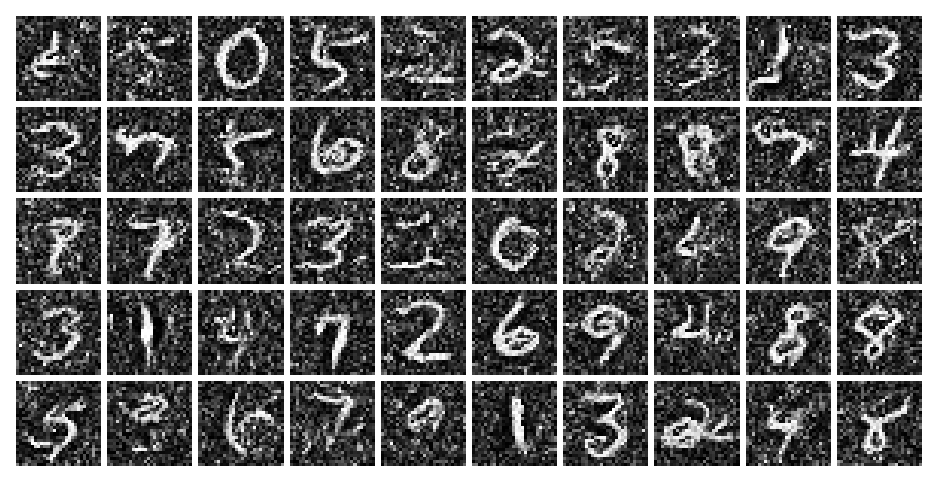

done sampling from model
OT train: 1740.9467
OT test: 1843.5469

=== Iteration 5 ===


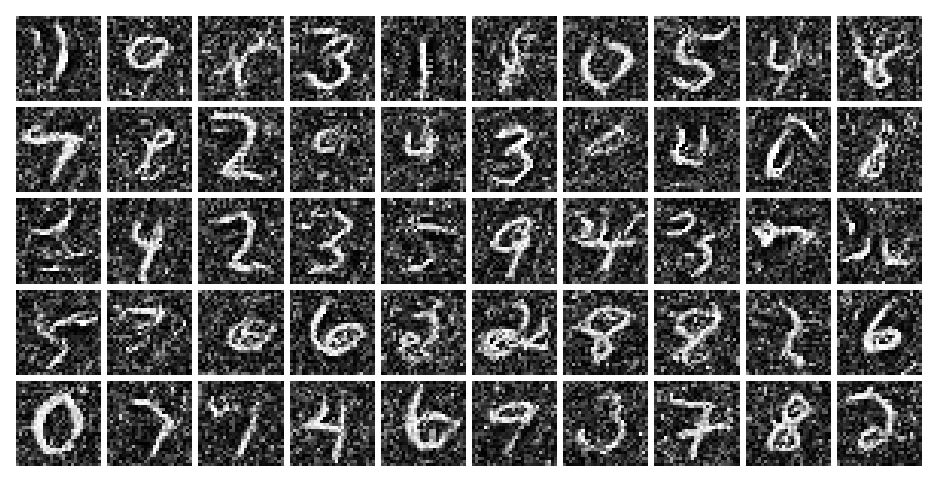

done sampling from model
OT train: 1910.0564
OT test: 1962.3827

=== Iteration 9 ===


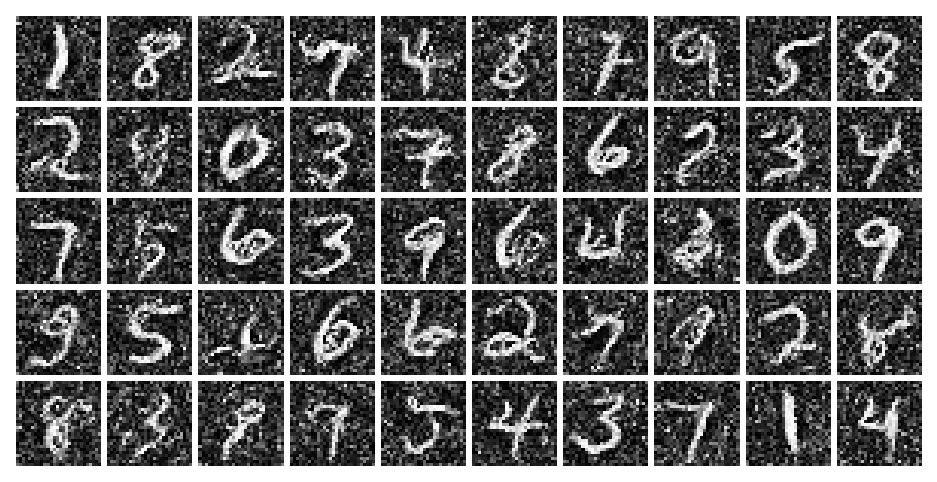

done sampling from model
OT train: 1516.8699
OT test: 1534.6221


In [12]:
import torch
import gc
from math import sqrt

ot_train = []
ot_test = []

loss_fn = SamplesLoss(
    "sinkhorn",
    p=2,
    blur=sqrt(0.1),
    debias=False,
    backend="tensorized"
)

for i in [2, 5, 9]:
    print(f"\n=== Iteration {i} ===")

    # ----------- Load model -----------
    state_dict = torch.load(os.path.join(DIR, f"models_mse/{i}.pth"), map_location=device)
    new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}

    img_shape = train_set[0][0].shape
    model_i = DDPM(T=1000, img_shape=img_shape)
    model_i.load_state_dict(new_state_dict)
    model_i.to(device)
    model_i.eval()

    new_reverse_q = MethodType(partial(reverse_q_reg, reg=0.01), model_i)
    model_i.reverse_q = new_reverse_q

    # ----------- Show sampled images -----------
    sampled_data = model_i.sample(num_imgs=50, skip=100)[-1].cpu()
    show_imgs(sampled_data, nrows=5)

    # ----------- Sample from model -----------
    sample = model_i.sample(num_imgs=1000, skip=100)[-1]
    _, feat_sample = netEncoder(sample)
    print("done sampling from model")

    # ----------- Sample from train set -----------
    dataset = train_loader.dataset
    indices = random.sample(range(len(dataset)), 1000)
    train = torch.stack([dataset[i][0] for i in indices]).to(device)
    _, feat_train = netEncoder(train)

    new_ot_train = loss_fn(feat_sample, feat_train)
    print(f"OT train: {new_ot_train.item():.4f}")
    ot_train.append(new_ot_train.item())

    # ----------- Sample from test set -----------
    dataset = test_loader.dataset
    indices = random.sample(range(len(dataset)), 1000)
    test = torch.stack([dataset[i][0] for i in indices]).to(device)
    _, feat_test = netEncoder(test)

    new_ot_test = loss_fn(feat_sample, feat_test)
    print(f"OT test: {new_ot_test.item():.4f}")
    ot_test.append(new_ot_test.item())

    # ----------- Clean up to prevent OOM -----------
    del model_i, sample, feat_sample, feat_train, feat_test, train, test
    torch.cuda.empty_cache()
    gc.collect()


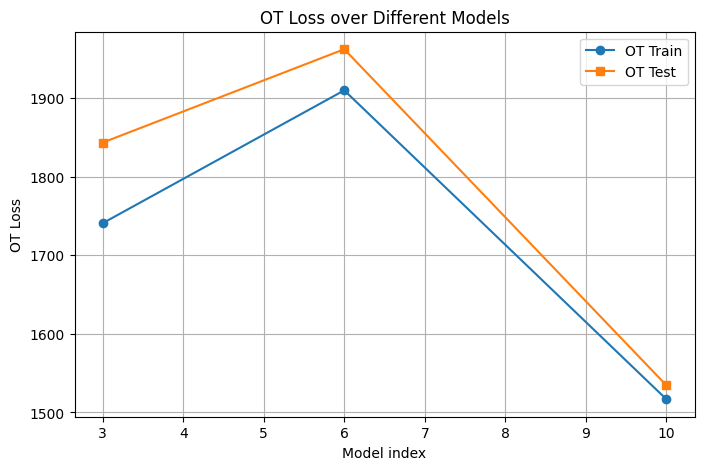

In [17]:
ot_train_vals = [t.item() if torch.is_tensor(t) else t for t in ot_train]
ot_test_vals = [t.item() if torch.is_tensor(t) else t for t in ot_test]

plt.figure(figsize=(8, 5))
plt.plot([3, 6, 10], ot_train_vals, marker='o', label="OT Train")
plt.plot([3, 6, 10], ot_test_vals, marker='s', label="OT Test")

plt.xlabel("Model index")
plt.ylabel("OT Loss")
plt.title("OT Loss over Different Models")
plt.legend()
plt.grid(True)
plt.show()

In [20]:

dataset = train_loader.dataset
indices = random.sample(range(len(dataset)), 1000)
train = torch.stack([dataset[i][0] for i in indices]).to(device)
_, feat_train = netEncoder(train)

# ----------- Sample from test set -----------
dataset = test_loader.dataset
indices = random.sample(range(len(dataset)), 1000)
test = torch.stack([dataset[i][0] for i in indices]).to(device)
_, feat_test = netEncoder(test)

# ---- New Graph: Ratios ----
# Convert tensors to floats
ot_train_vals = [t.item() if torch.is_tensor(t) else t for t in ot_train]
ot_test_vals = [t.item() if torch.is_tensor(t) else t for t in ot_test]

# Compute ratios
ratios_test_train = [test/train for test, train in zip(ot_test_vals, ot_train_vals)]
ratios_test_trainTest = [
    test / loss_fn(feat_train, feat_test).item()
    for test in ot_test_vals
]

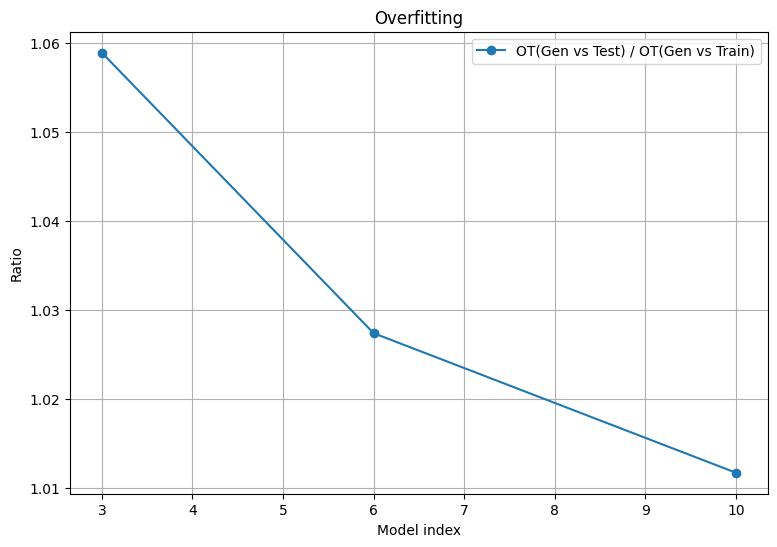

In [21]:
plt.figure(figsize=(9, 6))
plt.plot([3, 6, 10], ratios_test_train,
         marker='o', label="OT(Gen vs Test) / OT(Gen vs Train)")

plt.xlabel("Model index")
plt.ylabel("Ratio")
plt.title("Overfitting")
plt.legend()
plt.grid(True)
plt.show()


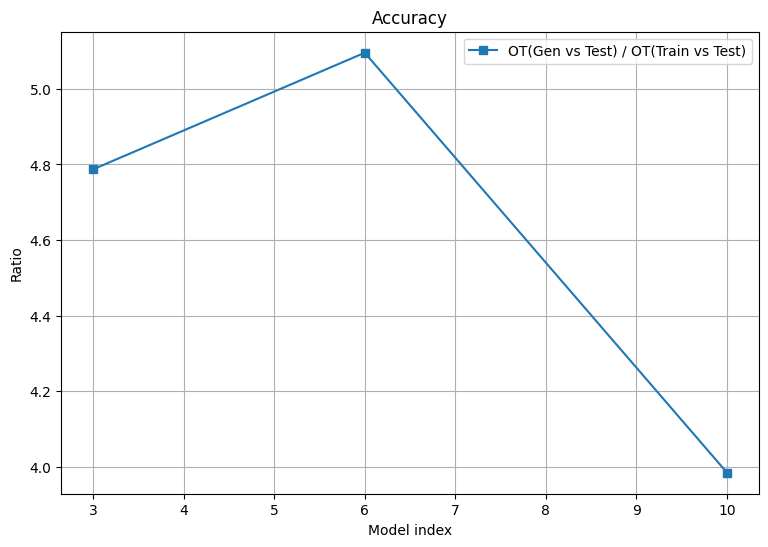

In [22]:
plt.figure(figsize=(9, 6))
plt.plot([3, 6, 10], ratios_test_trainTest,
         marker='s', label="OT(Gen vs Test) / OT(Train vs Test)")

plt.xlabel("Model index")
plt.ylabel("Ratio")
plt.title("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
